# Stellargraph example: Relational Graph Convolutional Network (RGCN) on the AIFB relational dataset

This example demonstrates how use an RGCN [1] on the AIFB dataset with stellargraph. This dataset can be downloaded [here](https://figshare.com/articles/AIFB_DataSet/745364). 

The following is a description of the dataset:

>The AIFB dataset describes the AIFB research institute in terms of its staff, research group, and publications. In (Bloehdorn et al 2007) the dataset was first used to predict the affiliation (i.e., research group) for people in the dataset. The dataset contains 178 members of a research group, however the smallest group contains only 4 people, so this one is removed from the dataset, leaving 4 classes.

The goal is to predict which research group a researcher belongs to.

[1] Modeling Relational Data with Graph Convolutional Networks. Thomas N. Kipf, Michael Schlichtkrull (2017). https://arxiv.org/pdf/1703.06103.pdf

First we load the required libraries.

In [1]:
from rdflib.extras.external_graph_libs import *
from rdflib import Graph, URIRef, Literal

import networkx as nx
from networkx.classes.function import info

import stellargraph as sg
from stellargraph.mapper.node_mappers import RelationalFullBatchNodeGenerator
from stellargraph.layer import RGCN

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

import sklearn
from sklearn import model_selection
from collections import Counter

/Users/kieranricardo/anaconda3/envs/stellar-demos/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kieranricardo/anaconda3/envs/stellar-demos/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kieranricardo/anaconda3/envs/stellar-demos/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

## Loading the data

We use rdf to load the relational dataset into a networkx directed multigraph. Relational datasets are inherently direct with multiple edges types so we use the MultiDiGraph datastructure to capture this information.

The relationship 'affilition' indicates whether a researcher is affiliated with a reseach group e.g. (researcher, research group, affilliation). We use this relationship to label the nodes in a dataset.  After this we remove the affilliation relationship. The idea here is to test whether we can recover a 'missing' relationship. 

The relation 'employs' is the inverse of 'affilliation' and we remove this as well - otherwise it would give away the answer.

In [2]:
data_filepath = os.path.expanduser(os.path.join("~", "data", "aifbfixed_complete.n3"))

graph = Graph()
graph.parse(data_filepath, format='n3')
g_nx = rdflib_to_networkx_multidigraph(graph)

affiliation = 'http://swrc.ontoware.org/ontology#affiliation'
employs = 'http://swrc.ontoware.org/ontology#employs'


people_nodes = [e[0] for e in g_nx.edges if (str(e[-1]) == affiliation)] # the node ids of the researches
labels = [e[1] for e in g_nx.edges if (str(e[-1]) == affiliation)] # the research group each researcher belongs to

# remove 'affiliation' and 'employs' relationships
edges_to_remove = [e for e in g_nx.edges if (str(e[-1]) == affiliation) or ((str(e[-1]) == employs))]
g_nx.remove_edges_from(edges_to_remove)

## Feature and target creation

We now create features and targets for machine learning.  Our nodes don't have features so we simply one-hot-encode each node and use there as our features and allow our model to learn from the graph structure.

In [3]:
# create an encoder
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

# create targets
# targets of researchers is a one hot encoded vector indicating which research group they belong to
# targets of non-researcher entities are set to zero vectors 
# (we're not interested in predicting anything about non-researcher node)

node_index = dict(zip(g_nx.nodes, range(len(g_nx.nodes))))
people_idx = np.array([node_index[node] for node in people_nodes])

people_targets = encoder.fit_transform(np.array(labels)[:, np.newaxis])

targets = np.zeros((len(g_nx.nodes), people_targets.shape[-1]))
targets[people_idx, :] = people_targets

# one-hot-encode the nodes to use a features for ML and store in a pandas array
encoder = sklearn.preprocessing.OneHotEncoder(sparse=False)

# index the node_data and targets dataframes by the nodes of the graph - this allows allows
# the nodes and edges of the graph to be matched with the targets and features
node_data = pd.DataFrame(encoder.fit_transform(np.array(list(g_nx.nodes))[:, np.newaxis]), index=g_nx.nodes)
targets = pd.DataFrame(targets, index=g_nx.nodes)

# split data into train and test
train_data, test_data, train_targets, test_targets = model_selection.train_test_split(
    node_data.loc[people_nodes], targets.loc[people_nodes], train_size=0.8, test_size=None
)

## Machine Learning Graph Creation

Now we create a StellarDiGraph object to encapsulate the graph structure and the node features.  We'll then use the StellarDiGraph to create training and testing generators for ML.

In [4]:
G = sg.StellarDiGraph(
    g_nx, node_features=node_data
)

In [5]:
generator = RelationalFullBatchNodeGenerator(G, sparse=True)

train_gen = generator.flow(train_data.index, targets=train_targets)
test_gen = generator.flow(test_data.index, targets=test_targets)

/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/u

/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/utils.py:51: RuntimeWarning: divide by zero encountered in float_power
  d = sp.diags(np.float_power(np.array(adj.sum(1)), -1).flatten(), 0)
/Users/kieranricardo/PycharmProjects/origin-stellargaph/stellargraph/stellargraph/core/u

## RGCN model creation and training

We use stellargraph to create an RGCN object. This creates a stack of relation graph convolutional layers. We add a softmax layer to transform the features created by RGCN into class predictions and create a keras model.  Then we train the model on the stellargraph generators.

Each RGCN layer creates a weight matrix for each relaitonship in the graph. If `num_bases==0` these weight matrices are completely independant. If `num_bases!=0` each weight matrix is a different linear combination of the same basis matrices - this introduces parameter sharing and reduces the number of the parameters in the model.  See the paper for more details.

In [6]:
rgcn = RGCN(
    layer_sizes=[16, 16], 
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    num_bases=10, 
    dropout=0.5,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
x_in, x_out = rgcn.node_model()
predictions = Dense(train_targets.shape[-1], activation='softmax')(x_out)
model = Model(inputs=x_in, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.01), metrics=['acc'])

In [8]:
model.fit_generator(
    train_gen,
    epochs=20)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1/1 [==============================] - 16s 16s/step - loss: 1.6105 - acc: 0.3169
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 1.5729 - acc: 0.5986
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 1.5135 - acc: 0.5845
Epoch 4/20
1/1 [==============================] - 5s 5s/step - loss: 1.4734 - acc: 0.6197
Epoch 5/20
1/1 [==============================] - 5s 5s/step - loss: 1.3937 - acc: 0.5915
Epoch 6/20
1/1 [==============================] - 5s 5s/step - loss: 1.2570 - acc: 0.6127
Epoch 7/20
1/1 [==============================] - 5s 5s/step - loss: 0.9566 - acc: 0.6901
Epoch 8/20
1/1 [==============================] - 6s 6s/step - loss: 1.0089 - acc: 0.6761
Epoch 9/20
1/1 [==============================] - 6s 6s/step - loss: 0.8503 - acc: 0.7042
Epoch 10/20
1/1 [==============================] - 6s 6s/step - loss: 0.6959 - acc: 0.7535
Epo

Now we assess the accuracy of our trained model on the test set - it does pretty well on this example dataset!

In [9]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.3670
	acc: 0.8889


## Node embeddings

Evaluate node embeddings as activations of the output of the last graph convolution layer in the GCN layer stack and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

To calculate the node embeddings rather than the class predictions, we create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings `x_out` rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# get embeddings for all people nodes
all_gen = generator.flow(people_nodes, targets=people_targets)
embedding_model = Model(inputs=x_in, outputs=x_out)
emb = embedding_model.predict_generator(all_gen)

In [14]:
X = emb.squeeze(0)
y = np.argmax(people_targets, axis=1)

if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=people_nodes)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=people_nodes)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

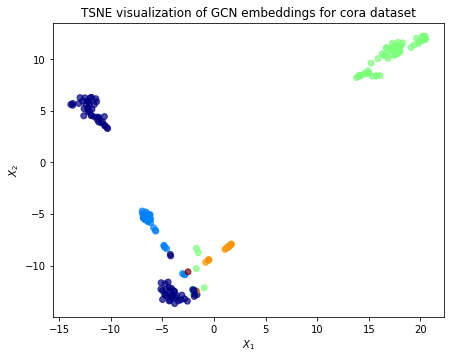

In [15]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GCN embeddings for cora dataset'.format(transform.__name__))
plt.show()

Aside from a slight overlap the classes are well seperated despite only using 2-dimensions. This indicates that our model is performing well at clustering the researchers into the right groups.